In [141]:
from pypdf import PdfReader
import re
import networkx as nx
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn import metrics

Code par Igor Grégoire pour le cours LINMA1691 : Théorie des Graphes 

# Extraction et traitement des données


## On extrait le texte du pdf

In [142]:
reader = PdfReader('Star_Wars_Episode_3_Revenge_Of_The_Sith.pdf')
npages = len(reader.pages)
text = ''
for i in range(npages):
    page = reader.pages[i]
    text += page.extract_text()


## On traite le texte pour diviser le script en scènes

In [143]:
temp = text.split('\n')
data = []

# On localise les scènes
scenes = []
for i in range(len(temp)):
    # George Lucas a oublié de mettre des points à tous les INT et EXT...
    if ("INT" in temp[i] or "EXT" in temp[i]) and "INTERCUT" not in temp[i]:
        scenes.append(i)

# On divise les scènes dans data
for i in range(len(scenes)-1):
    data.append(temp[scenes[i]:scenes[i+1]])
data.append(temp[scenes[-1]:])




## On cherche les personnages parlant dans chaque scène

In [144]:
characters = {}
pattern = r'\b[A-Za-z][A-Za-z0-9\- ]+:'
for i in range(len(data)):
    temp = ''.join(data[i][1:])
    personnages = re.findall(pattern, temp)
    personnages = [personnages[m].upper() for m in range(len(personnages))]
    if i not in characters:
        characters[i] = []
    for personnage in personnages:
        if personnage[:-1] not in characters[i]:
            characters[i].append(personnage[:-1])

## On corrige les fautes de frappe

In [145]:
error = 0
# G-3PO
characters[161].remove('G-3PO')
error += 1
 
# Qui -Gon
characters[221].remove('QUI -GON')
error += 1

# ANAKINN
characters[52].remove('ANAKINN')
error += 1

# Obi-Wan  (avec espace)
characters[85].remove('OBI-WAN ')
error += 1

# Dabth sidious
characters[140].remove('DABTH SIDIOUS')
characters[140].append('DARTH SIDIOUS')
error += 1

# Some errors
characters[7].remove(characters[7][3])
characters[129].remove(characters[129][0])
characters[115].remove(characters[115][0])
characters[104].remove(characters[104][2])
error += 4

for i in characters:
    if 'MACE' in characters[i]:
        characters[i].remove('MACE')
        if "MACE WINDU" not in characters[i]:
            characters[i].append('MACE WINDU')
        error += 1

    if 'MACE WLNDU' in characters[i]:
        characters[i].remove('MACE WLNDU')
        if "MACE WINDU" not in characters[i]:
            characters[i].append('MACE WINDU')
        error += 1

    if 'BAIL' in characters[i]:
        characters[i].remove('BAIL')
        if "BAIL ORGANA" not in characters[i]:
            characters[i].append('BAIL ORGANA')
        error += 1

    if 'DARTH SLDIOUS' in characters[i]:
        characters[i].remove('DARTH SLDIOUS')
        if "DARTH SIDIOUS" not in characters[i]:
            characters[i].append('DARTH SIDIOUS')
        error += 1
    
    if 'GLDDEAN DANU' in characters[i]:
        characters[i].remove('GLDDEAN DANU')
        if "GIDDEAN DANU" not in characters[i]:
            characters[i].append('GIDDEAN DANU')
        error += 1
    
    if "FANGZAR" in characters[i]:
        characters[i].remove('FANGZAR')
        if "FANG ZAR" not in characters[i]:
            characters[i].append('FANG ZAR')
        error += 1
    
    if "THREEPIO" in characters[i]:
        characters[i].remove('THREEPIO')
        if "C-3PO" not in characters[i]:
            characters[i].append('C-3PO')
        error += 1

print("Nombre d'erreurs (hors fautes de majuscule): ", error)

Nombre d'erreurs (hors fautes de majuscule):  28


# Début du graphe

## Liste d'adjacence

In [146]:
nodes = []
edges = []

for i in characters:
    if len(characters[i]) >= 2:
        edges.append(characters[i])

    for j in characters[i]:
        if j not in nodes:
            nodes.append(j)
            
# sort nodes alphabetically
nodes.sort()
Nnodes = len(nodes)

# Faire la liste d'adjacence
adj = {}
for node in nodes:
    adj[node] = []

# Remplir la liste d'adjacence
for edge in edges:
    for i in range(len(edge)):
        adj[edge[i]] += edge[:i] + edge[i+1:]

for i in nodes:
    print(i)

AAYLA
ANAKIN
AT-ST CLONE SERGEANT
BAIL ORGANA
BANA BREEMU
BATTLE DROID
BLY
BODYGUARD
BODYGUARD I
C-3PO
CAPTAIN
CAPTAIN ANTILLES
CAPTAIN TYPHO
CHI EEKWAY
CLONE CAPTAIN
CLONE COMMANDER APPO
CLONE COMMANDER BACARA
CLONE COMMANDER CODY
CLONE COMMANDER GREE
CLONE COMMANDER THIRE
CLONE PILOT
CLONE PILOT 2
CLONE SERGEANT
CLONE TROOPER
COUNT DOOKU
CREATURE
DARTH SIDIOUS
DARTH VADER
DROID 1
DROID 2
FANG ZAR
FLRESHIP PILOT
GENERAL GRIEVOUS
GIDDEAN DANU
GUARD
JAR JAR
KL-ADI-MUNDI
MACE WINDU
MAS AMEDDA
MEDICAL DROID
MON MOTHMA
MOTEE
NUTE GUNRAY
OBI-WAN
ODD BALL
PADME
PALPATINE
PILOT
PLO KOON
QUI-GON
ROYAL GUARD
RUNE HAAKO
SUPER BATTLE DROID
SUPER BATTLE DROID 1
SUPER BATTLE DROID 2
SUPER BATTLE DROID G21
SUPER BATTLE DROID R77
TERR TANEEL
TLON MEDON
WRANGLER
YODA
YOUNGLINGS


## Création du graphe

In [147]:
# Graphe entier
G = nx.Graph()

for i in nodes:
    G.add_node(i)

for i in G.nodes():
    for j in adj[i]:
        if not G.has_edge(i, j):
            G.add_edge(i, j, weight=1)
        else:
            G[i][j]['weight'] += 1

### Plot du graphe

Graph with 62 nodes and 151 edges


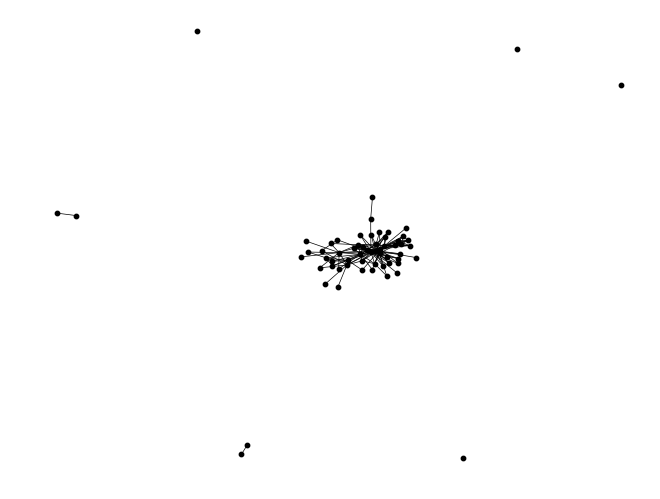

In [148]:
g_draw = G
pos = nx.spring_layout(g_draw)
nx.draw(g_draw, pos, node_color='black', node_size=10, width=0.5)
print(G)
#plt.savefig("graphG.png")

### Degrees

Text(0.5, 1.0, 'Degree distribution')

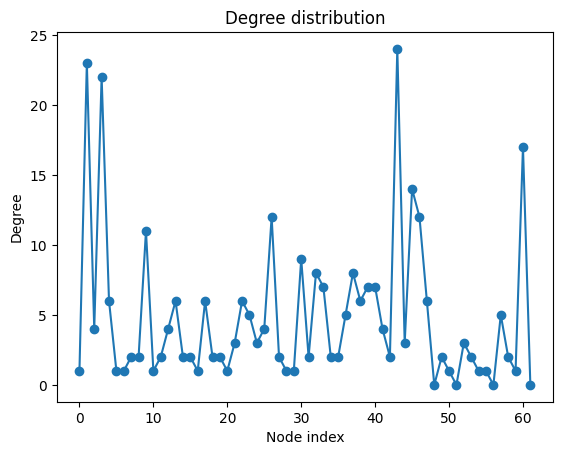

In [149]:
degrees = [G.degree(node) for node in nodes]
plt.plot(degrees,  linestyle='-', marker='o')
plt.xlabel('Node index')
plt.ylabel('Degree')
plt.title('Degree distribution')


Text(0.5, 1.0, 'Degree distribution')

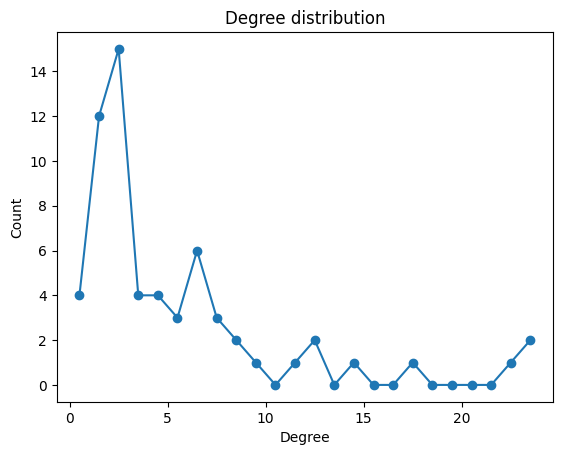

In [150]:
b_width = 1
bins = np.arange(min(degrees), max(degrees)+b_width, b_width)
hist, bins = np.histogram(degrees, bins = bins)
center_bins = [l+b_width/2 for l in bins[:-1]]

plt.plot(center_bins, hist, marker = "o")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution")


## Composantes connexes
Identification des composantes connexes

In [151]:
connect = nx.is_connected(G)
N_connected = nx.number_connected_components(G)
max_connected = max(nx.connected_components(G), key=len)
max_cc = G.subgraph(max_connected)



print("Le graphe est-il connexe ? ", connect)
print("Nombre de composantes connexes : ", N_connected)


Le graphe est-il connexe ?  False
Nombre de composantes connexes :  7


On plot la composante connexe la plus grande

Graph with 54 nodes and 149 edges


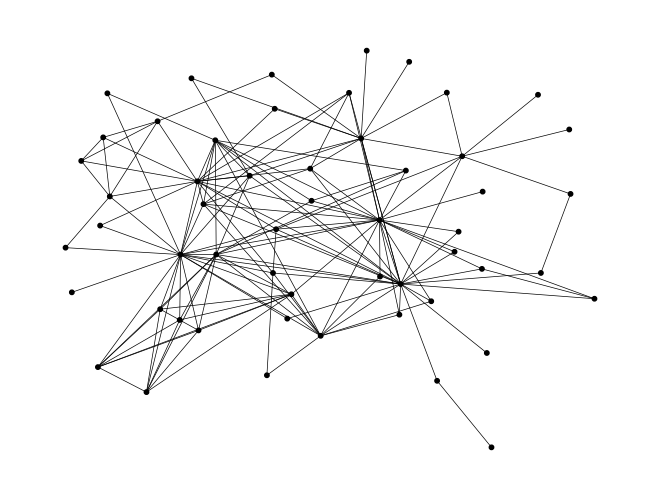

In [152]:
cc_draw = max_cc

color = np.array(["black"] * len(max_cc.nodes()))

# pos = nx.spring_layout(cc_draw)
pos = nx.kamada_kawai_layout(cc_draw)
# pos = nx.arf_layout(cc_draw)
nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5)
#plt.savefig("graphCC.png")

print(max_cc)

## Coloriage des noeuds

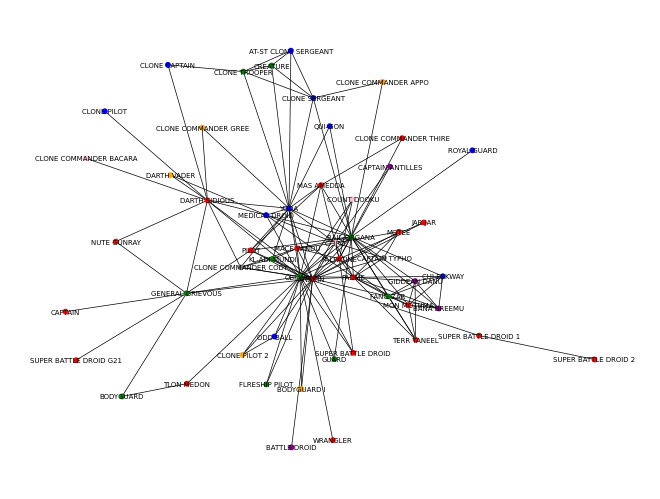

In [153]:
coloring = nx.coloring.greedy_color(max_cc, strategy='largest_first')
color = []
list_color = ["red", "blue", "green", "purple", "orange", "pink", "grey", "cyan"]
for i in coloring:
    color.append(list_color[coloring[i]])

pos = nx.spring_layout(cc_draw)
nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5, with_labels=True, font_size=5)

## Spectral clustering

In [154]:
adjacency_matrix = nx.adjacency_matrix(max_cc)
# pos = nx.spring_layout(cc_draw)
pos = nx.kamada_kawai_layout(cc_draw)
# pos = nx.shell_layout(cc_draw)
# pos = nx.arf_layout(cc_draw)

c:\Users\grego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Silhouette score:  -0.040992493372625366


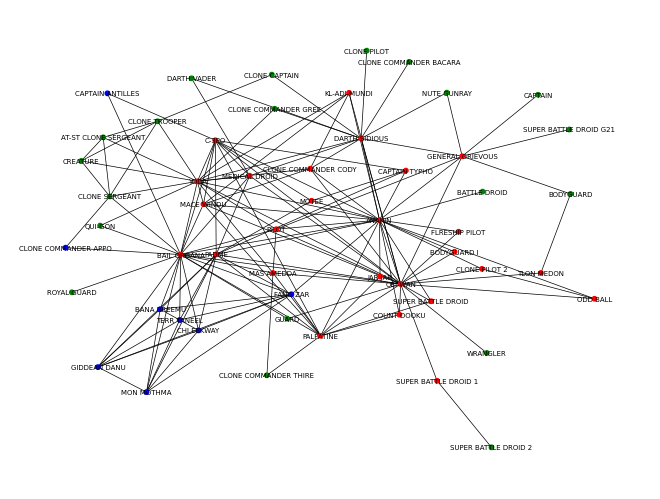

In [155]:
sc = SpectralClustering(3, affinity='nearest_neighbors', n_init=100)
sc.fit(adjacency_matrix)
labels = sc.labels_

# Draw the graph with the clustering
color = []
for i in labels:
    color.append(list_color[i])

nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5, with_labels=True, font_size=5)

silhouette = metrics.silhouette_score(adjacency_matrix, labels, metric='euclidean')
print("Silhouette score: ", silhouette)
plt.savefig("graphClustering.png")

In [159]:
nodes_cc = list(max_cc.nodes())
c1 = []
c2 = []
c3 = []

for i in range(len(nodes_cc)):
    if labels[i] == 0:
        c1.append(nodes_cc[i])
    elif labels[i] == 1:
        c2.append(nodes_cc[i])
    else:
        c3.append(nodes_cc[i])

for i in c3:
    print(i)


AT-ST CLONE SERGEANT
BATTLE DROID
BODYGUARD
CAPTAIN
CLONE CAPTAIN
CLONE COMMANDER BACARA
CLONE COMMANDER GREE
CLONE COMMANDER THIRE
CLONE PILOT
CLONE SERGEANT
CLONE TROOPER
CREATURE
DARTH VADER
GUARD
NUTE GUNRAY
QUI-GON
ROYAL GUARD
SUPER BATTLE DROID 2
SUPER BATTLE DROID G21
WRANGLER
